In [1]:
import xarray as xr
import pandas as pd
import gc
from tqdm import tqdm
from glob import glob

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import time
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shapereader

In [2]:
def setup_globe(ax):
#     ax.set_global() 
    ax.set_extent([-180,180,-60,75],crs=ccrs.PlateCarree())
    ax.coastlines(zorder=5)
#     ax.add_feature(cartopy.feature.LAND, facecolor='lightgray',zorder=0)
    ax.add_feature(cartopy.feature.LAKES, facecolor='none',edgecolor='black',
                   linewidth=0.5,zorder=5)
    
    ax.add_feature(cartopy.feature.BORDERS,
                   facecolor='none',
                   edgecolor='black',
                   linewidth=0.5,zorder=5)


def setup_colorbar_text(ax,p,title_text):
    ax.set_xlabel("")
    ax.set_ylabel("")
    cbar = plt.colorbar(p, ax=ax,
                    orientation="vertical",
                    fraction=0.1,
                    shrink=0.75,
                    pad=0.02,
                    aspect=30,
                    extend="neither")
    g = ax.gridlines(color='grey', linestyle='--', draw_labels=False,zorder=4)
    g.xlocator = mticker.FixedLocator([-90, 0, 90])
    lon_formatter = LongitudeFormatter()#zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_title(title_text)
    
def plot_scatter(ax,df,vmin,vmax,cmap):
    df_temp = df.copy()
    df_temp["lon_new"] = np.where(df_temp['lon'] <= 180, 
                                  df_temp['lon'], 
                                  df_temp['lon']-360)
    norm = matplotlib.colors.BoundaryNorm(np.arange(18),256)
    p = ax.scatter(df_temp["lon"],df_temp["lat"],c=df_temp[0],
                   s=0.5,
                   vmin=vmin,
                   vmax=vmax,
                   cmap=cmap,
                   norm=norm,
                   zorder=3,rasterized=True)
    
    return p
    
def plot_map(df,i,vmin,vmax,cmap,title_text):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    setup_globe(ax)
    ax.set_yticks(np.array([-60,-30,0,30,60]), crs=ccrs.PlateCarree())
    ax.set_xticks(np.linspace(-90, 90, 3), crs=ccrs.PlateCarree())
    
#     if i==0: 
#         ax.set_yticks(np.array([-60,-30,0,30,60]), crs=ccrs.PlateCarree())
#         ax.set_xticks(np.linspace(-90, 90, 3), crs=ccrs.PlateCarree())
#     elif i==1:
#         ax.set_xticks(np.linspace(-90, 90, 3), crs=ccrs.PlateCarree())
    p = plot_scatter(ax,df,vmin,vmax,cmap)
    setup_colorbar_text(ax,p,title_text) 

In [3]:
vari_ls = ["QBOT","UBOT","VBOT",
           "TREFHT",
           "FLNS","FSNS",
           "PRECT","PRSN"]

path_ls = glob("/glade/scratch/zhonghua/CMIP5-RCP85_csv/*")
model_ls = [path.split("/")[-1] for path in path_ls]
save_dir = "/glade/scratch/zhonghua/feature_dist_95/"

## get global extremes from CMIP features (2.5%, 97.5%)

In [4]:
%%time
year = "2061"
for path in tqdm(path_ls):
    model = path.split("/")[-1]
    df_tmp = pd.read_csv(path+"/"+year+".csv")[["lat","lon","TREFHT"]]
    min_dist = df_tmp[["lat","lon","TREFHT"]].groupby(["lat","lon"]).quantile(0.025)
    max_dist = df_tmp[["lat","lon","TREFHT"]].groupby(["lat","lon"]).quantile(0.975)
    min_dist.to_csv(save_dir+model+"_min.csv")
    max_dist.to_csv(save_dir+model+"_max.csv")
    del model, df_tmp, min_dist, max_dist
    gc.collect()

100%|██████████| 17/17 [11:31<00:00, 40.66s/it]

CPU times: user 10min 42s, sys: 48.2 s, total: 11min 30s
Wall time: 11min 31s


## get global extrems from CESM (min, max)

In [5]:
%%time
year = "2061"
model = "CESM"
path = "/glade/scratch/zhonghua/ensem_training_data/"
df_tmp = pd.read_csv(path+"/"+year+".csv")[["lat","lon","TREFHT"]]
min_dist = df_tmp[["lat","lon","TREFHT"]].groupby(["lat","lon"]).min()
max_dist = df_tmp[["lat","lon","TREFHT"]].groupby(["lat","lon"]).max()
min_dist.to_csv(save_dir+model+"_min.csv")
max_dist.to_csv(save_dir+model+"_max.csv")
del model, df_tmp, min_dist, max_dist
gc.collect()

CPU times: user 1min 14s, sys: 8.64 s, total: 1min 22s
Wall time: 1min 24s


0

## merge CMIP features

In [4]:
df_min = pd.read_csv(save_dir+model_ls[0]+"_min.csv").rename(columns={"TREFHT":model_ls[0]})
df_max = pd.read_csv(save_dir+model_ls[0]+"_max.csv").rename(columns={"TREFHT":model_ls[0]})
for i in range(1,len(model_ls)):
    df_min_tmp = pd.read_csv(save_dir+model_ls[i]+"_min.csv").rename(columns={"TREFHT":model_ls[i]})
    df_min = pd.merge(df_min, df_min_tmp, on=["lat","lon"],how="inner")
    df_max_tmp = pd.read_csv(save_dir+model_ls[i]+"_max.csv").rename(columns={"TREFHT":model_ls[i]})
    df_max = pd.merge(df_max, df_max_tmp, on=["lat","lon"],how="inner")
    del df_min_tmp, df_max_tmp
    gc.collect()
    
df_CESM_min = pd.read_csv(save_dir+"CESM"+"_min.csv")
df_CESM_max = pd.read_csv(save_dir+"CESM"+"_max.csv")

In [5]:
(df_min[["lat","lon"]] - df_CESM_min[["lat","lon"]]).describe()

,lat,lon
count,4439.0,4439.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [6]:
min_stat = {"lat":df_min.lat,
            "lon":df_min.lon}

max_stat = {"lat":df_max.lat,
            "lon":df_max.lon}

for model in model_ls:
    min_stat[model]=df_min[model]>=df_CESM_min["TREFHT"]
    max_stat[model]=df_max[model]<=df_CESM_max["TREFHT"]

In [7]:
min_df = pd.DataFrame(min_stat).set_index(["lat","lon"]).sum(axis=1)
max_df = pd.DataFrame(max_stat).set_index(["lat","lon"]).sum(axis=1)

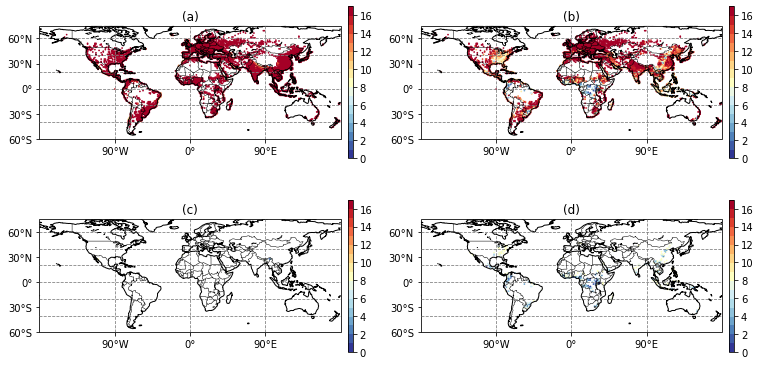

In [8]:
fig = plt.figure(figsize=(10.8,5.8))
cmap="RdYlBu_r"

plot_map(min_df.reset_index(),
         0, 0, 17,
         cmap,"(a)")

plot_map(max_df.reset_index(),
         1, 0, 17,
         cmap,"(b)")

plot_map(min_df.reset_index()[min_df.reset_index()[0]<9],
         2, 0, 17,
         cmap,"(c)")

plot_map(max_df.reset_index()[max_df.reset_index()[0]<9],
         3, 0, 17,
         cmap,"(d)")

plt.tight_layout()
# plt.savefig("../../figures_min/figures_rmse_min.pdf",dpi=188)
plt.show()